In [1]:
import time
import sys
import os

sys.path.append(os.path.abspath("../DP/Env"))
sys.path.append(os.path.abspath("../DP/Algorithms/"))
sys.path.append(os.path.abspath("../DP/Visual/"))


sys.path.append(os.path.abspath("../Instances"))


from Knapsack import KnapsackEnv
from InsKnapsack import generate_knapsack_instance

from value_iteration import value_iteration
from policy_evaluation import policy_evaluation
from policy_iteration import policy_iteration

from value_states import value_states_visual
from policy_dag import draw_policy_dag


In [2]:
weights, values, capacity = generate_knapsack_instance(
    n=15,
    w_min=1,  w_max=15,
    v_min=1,  v_max=10,
    capacity_ratio=0.25,
)

print("weights =", weights)
print("values  =", values)
print("capacity =", capacity)

weights = [5, 1, 6, 10, 2, 5, 12, 8, 2, 4, 1, 3, 2, 5, 12]
values  = [10, 2, 5, 4, 9, 1, 3, 3, 6, 1, 10, 8, 3, 2, 3]
capacity = 20


In [3]:
env = KnapsackEnv(weights, values, capacity)
print(env)

KnapsackEnv(#_Objetos = 15, Capacidad = 20, #_Estados = 336)


In [4]:
# Construye un diccionario «política» que asigna a cada estado s
# (tupla (i, c) = índice del objeto, capacidad restante)
# la acción 'take' cuando sea LEGAL tomar el objeto,
# y 'skip' en caso contrario.

propose_policy = {
    s: ('take' if 'take' in env.actions(s) else 'skip')
    for s in env.state_space()
}

policy = propose_policy.copy()

In [5]:
# 1. Cronometrar todo el proceso
t0 = time.perf_counter()

# 2. Evaluar la política (valor esperado de cada estado)
V = policy_evaluation(env, propose_policy)
dt  = time.perf_counter() - t0  

# 3. Simular una ejecución para saber qué objetos se toman realmente
objs_tomados   = []      # índices de objetos
peso_acumulado = 0

state = env.reset()      # (i, c) = (0, capacidad)
done  = False
while not done:
    action = policy[state]
    if action == "take":
        idx_obj = state[0]                # i = índice del objeto actual
        objs_tomados.append(idx_obj)
        peso_acumulado += env.weights[idx_obj]
    state, _, done = env.step(action)

FO  = env.total_reward                    # valor total conseguido

# 4. Mostrar resultados

print("Objetos seleccionados:")
for idx in objs_tomados:
    w, v = env.weights[idx], env.values[idx]
    print(f"  • Obj {idx:>2}: peso={w}, valor={v}")
    
print(f"\nTiempo de ejecución: {dt:.6f} s")
print(f"FO (valor total):    {FO}")
print(f"Presupuesto usado:   {peso_acumulado}/{env.capacity}")


Objetos seleccionados:
  • Obj  0: peso=5, valor=10
  • Obj  1: peso=1, valor=2
  • Obj  2: peso=6, valor=5
  • Obj  4: peso=2, valor=9
  • Obj  5: peso=5, valor=1
  • Obj 10: peso=1, valor=10

Tiempo de ejecución: 0.000785 s
FO (valor total):    37
Presupuesto usado:   20/20


In [6]:
# -------------------------------------------------------------------
# 1.  Obtener la política óptima y cronometrar el proceso completo
# -------------------------------------------------------------------
t0 = time.perf_counter()
star_policy, V_star = policy_iteration(env, policy)
elapsed = time.perf_counter() - t0

# -------------------------------------------------------------------
# 2.  Recorrer el episodio con la política óptima para saber qué toma
# -------------------------------------------------------------------
state      = env.reset()          # (i, c) = (0, capacidad)
chosen     = []                   # índices de los objetos tomados
peso_tot   = 0
valor_tot  = 0

while not env.is_terminal(state):
    a = star_policy[state]
    if a == "take":
        idx = state[0]                  # índice del objeto actual
        chosen.append(idx)
        peso_tot  += env.weights[idx]
        valor_tot += env.values[idx]
    state, _ = env.sim_step(state, a)
    


# -------------------------------------------------------------------
# 3.  Mostrar resultados en el formato requerido
# -------------------------------------------------------------------
print("Objetos seleccionados:")
for idx in chosen:
    w, v = env.weights[idx], env.values[idx]
    print(f"  • Obj {idx:>2}: peso={w}, valor={v}")

print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# FO = retorno total; equivale a V_opt[(0, env.capacity)] si gamma=1
print(f"FO (valor total):    {valor_tot}")

print(f"Presupuesto usado:   {peso_tot}/{env.capacity}")


Objetos seleccionados:
  • Obj  0: peso=5, valor=10
  • Obj  1: peso=1, valor=2
  • Obj  2: peso=6, valor=5
  • Obj  4: peso=2, valor=9
  • Obj  8: peso=2, valor=6
  • Obj 10: peso=1, valor=10
  • Obj 11: peso=3, valor=8

Tiempo de ejecución: 0.006168 s
FO (valor total):    50
Presupuesto usado:   20/20


In [7]:
# -------------------------------------------------------------------
# 1.  Obtener la política óptima y cronometrar el proceso completo
# -------------------------------------------------------------------
t0 = time.perf_counter()
opt_policy, V_opt = value_iteration(env)
elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

env.report_from_policy(opt_policy)



Tiempo de ejecución: 0.002734 s
Objetos seleccionados:
  • Obj  0: peso=5, valor=10
  • Obj  1: peso=1, valor=2
  • Obj  2: peso=6, valor=5
  • Obj  4: peso=2, valor=9
  • Obj  8: peso=2, valor=6
  • Obj 10: peso=1, valor=10
  • Obj 11: peso=3, valor=8
FO (valor total):    50
Presupuesto usado:   20/20


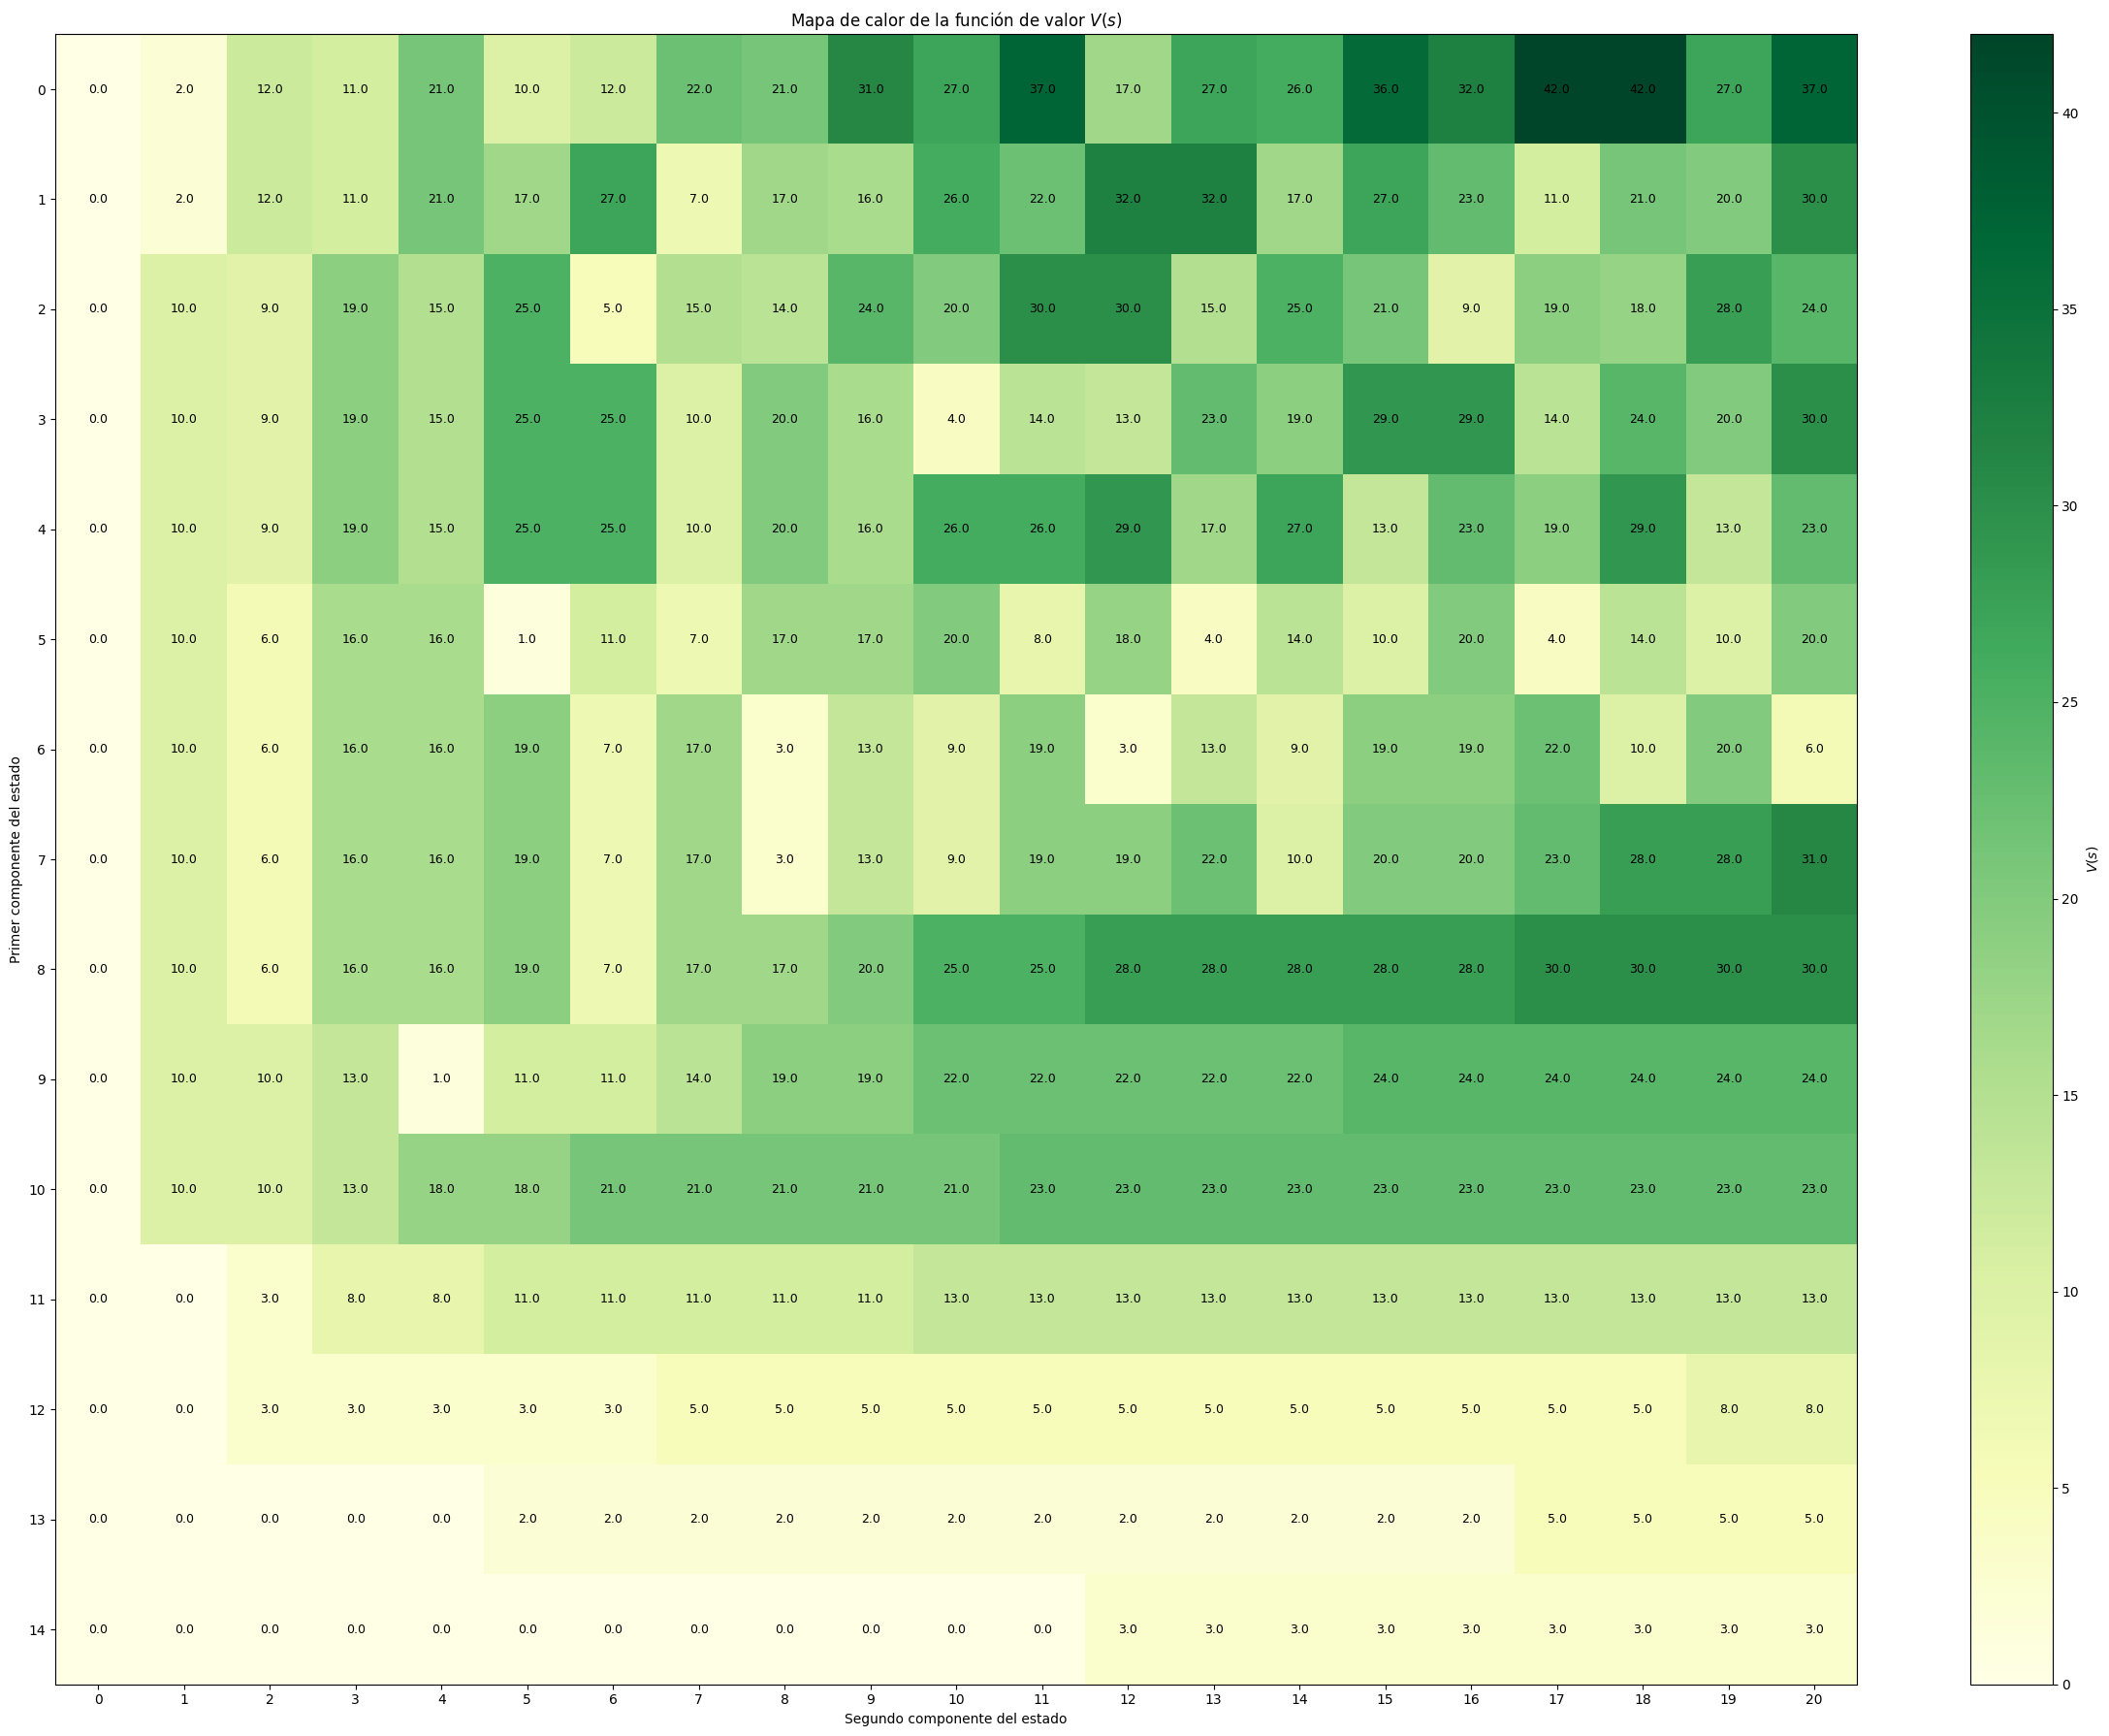

In [8]:
value_states_visual(env, V)

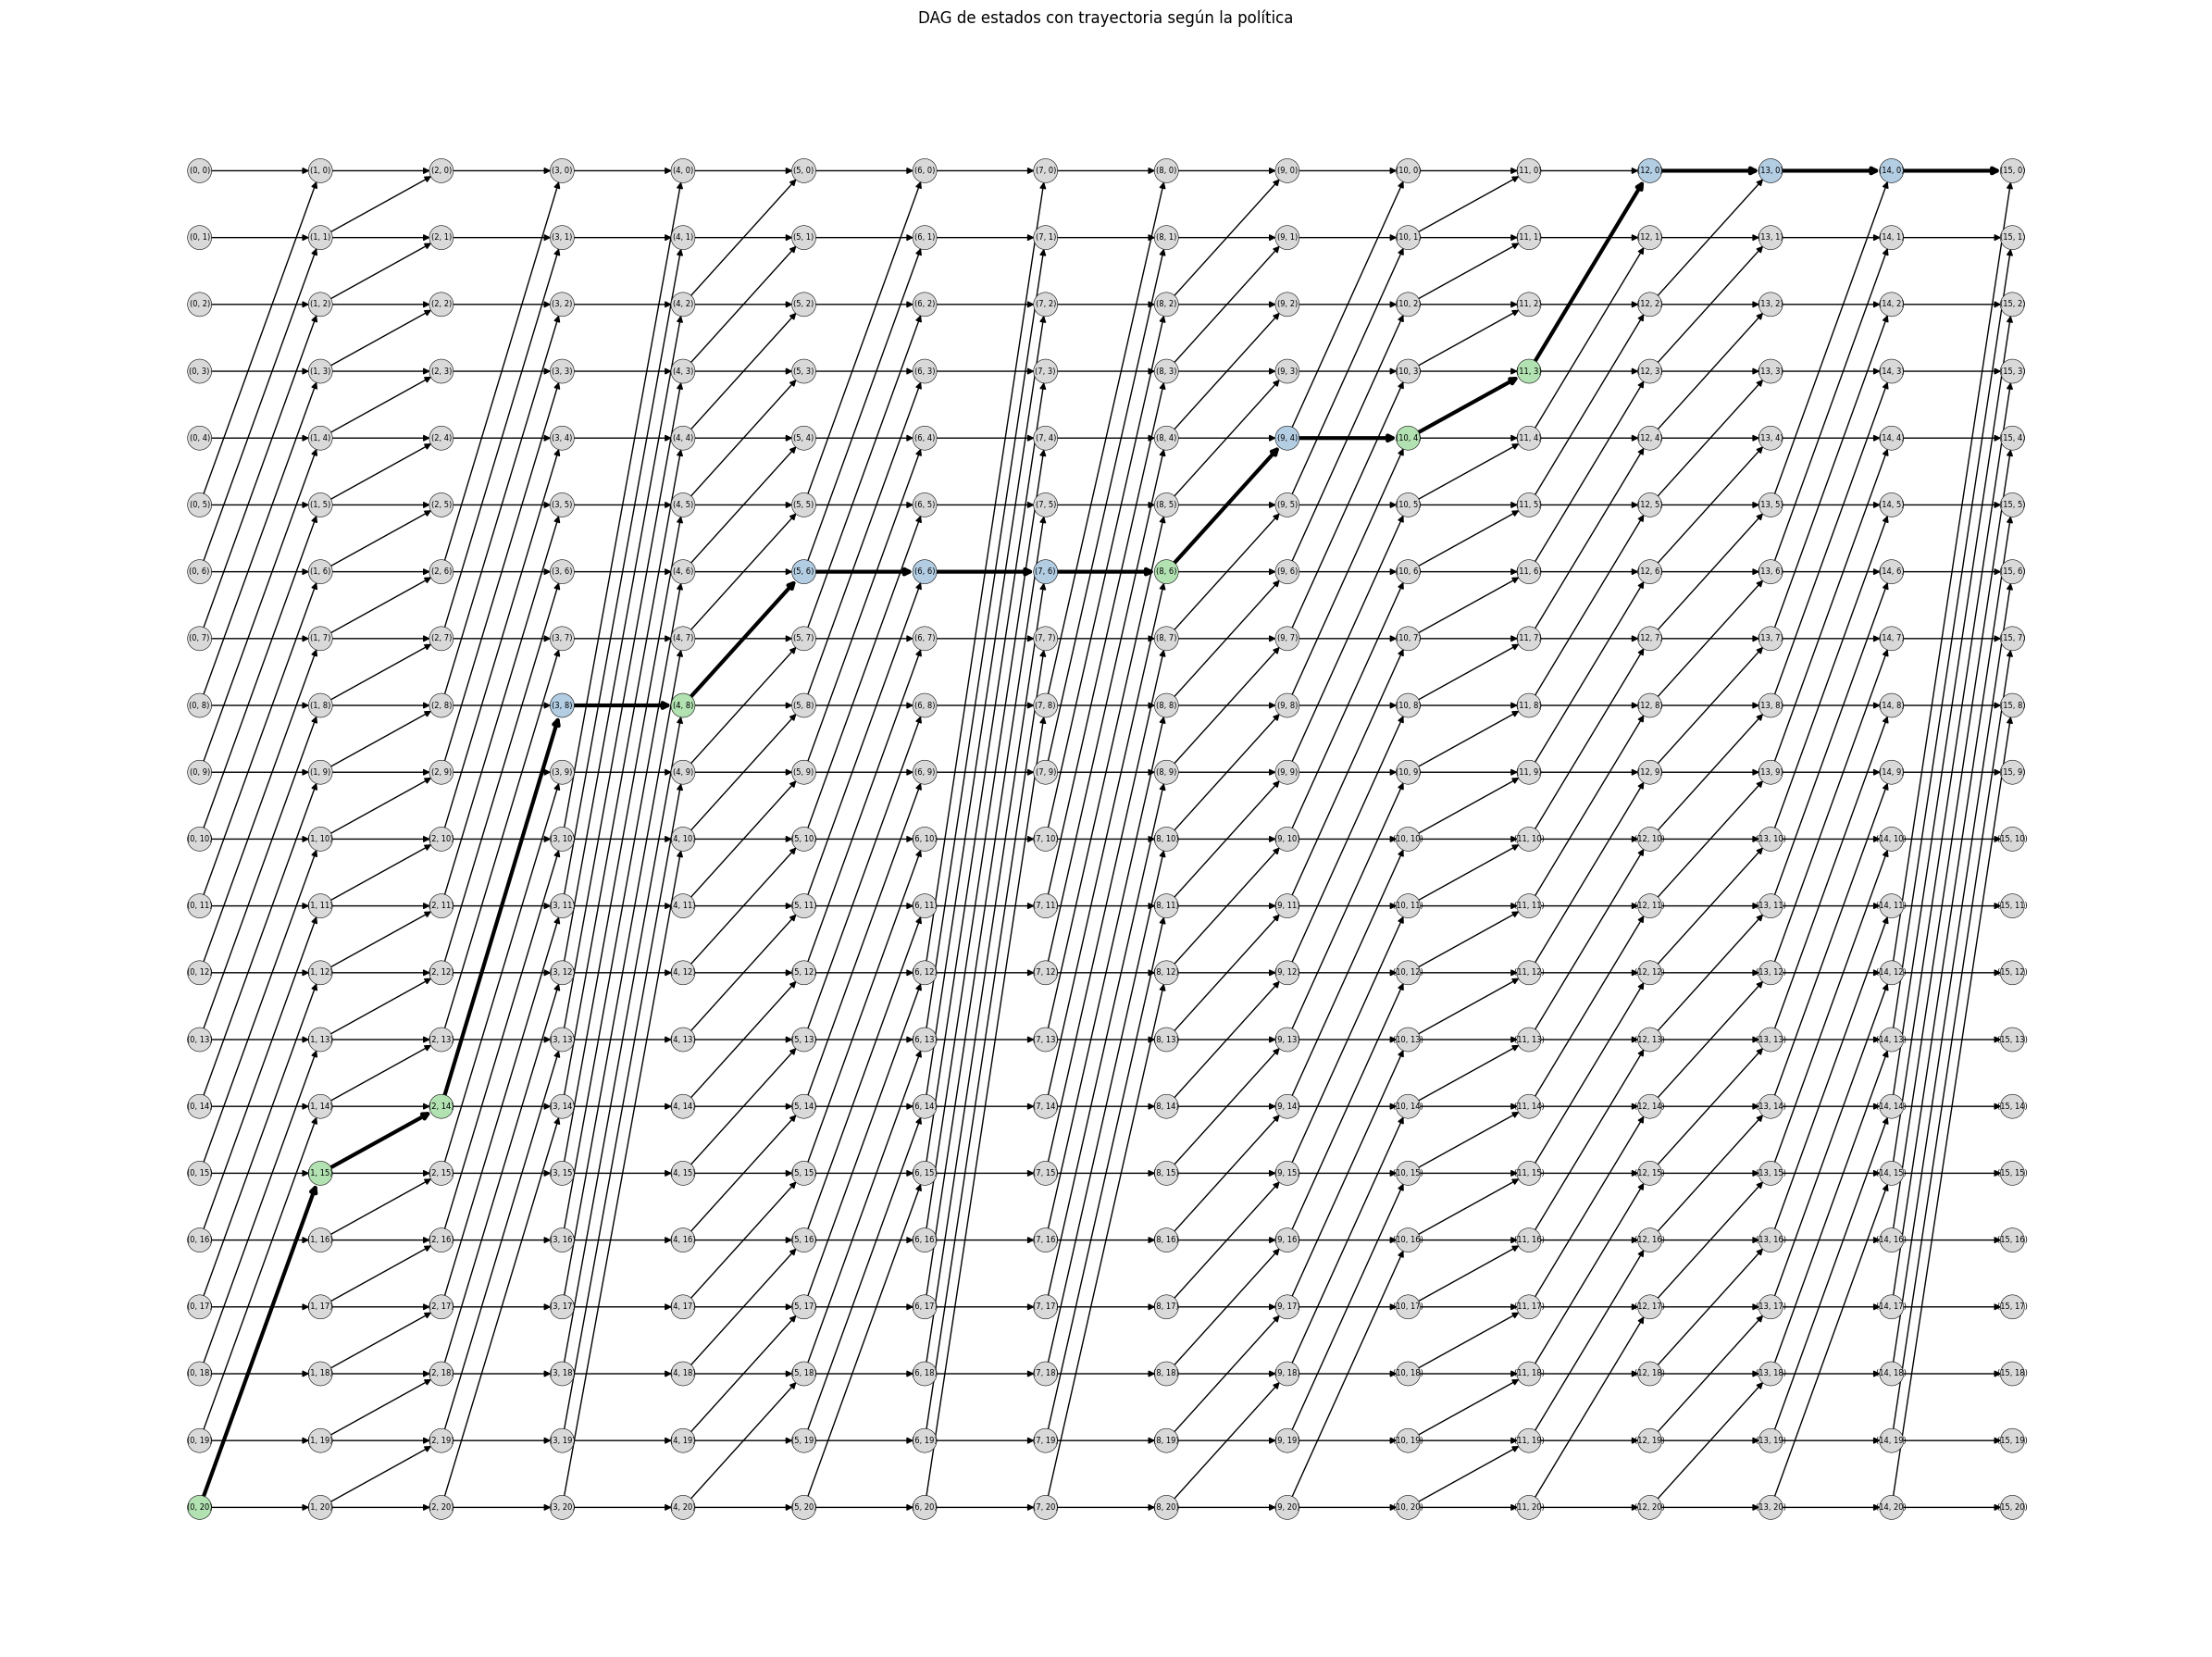

In [9]:
draw_policy_dag(env, opt_policy, initial_state=(0, env.capacity))